In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dtnnlib as dtnn
# import resnet_cifar

In [4]:
import scipy.stats as st

## Image Dot Product

In [62]:
W = np.ones((5,5))

In [63]:
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

In [64]:
G = gkern(5, 2.5)
G = G/G.max()

In [65]:
G

array([[0.02504279, 0.09989847, 0.15824913, 0.09989847, 0.02504279],
       [0.09989847, 0.39850617, 0.63127345, 0.39850617, 0.09989847],
       [0.15824913, 0.63127345, 1.        , 0.63127345, 0.15824913],
       [0.09989847, 0.39850617, 0.63127345, 0.39850617, 0.09989847],
       [0.02504279, 0.09989847, 0.15824913, 0.09989847, 0.02504279]])

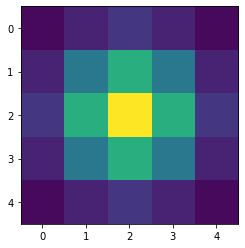

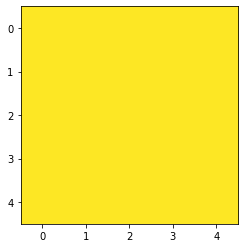

In [66]:
plt.imshow(G, vmin=0, vmax=1)
plt.show()
plt.imshow(W, vmin=0, vmax=1)
plt.show()

In [67]:
alphas = np.linspace(0, 1, num=10)

## For dot products

In [99]:
### From zeros to G
dot_prods0 = []
for alpha in alphas:
    A = alpha*G #+ (1-alpha)*W
    dp = (A*G).sum() ### calculating the dot product
#     dp = dp/np.linalg.norm(A)
    dot_prods0.append(dp)

In [100]:
dot_prods0

[0.0,
 0.37908563424140523,
 0.7581712684828105,
 1.1372569027242156,
 1.516342536965621,
 1.8954281712070262,
 2.2745138054484313,
 2.6535994396898364,
 3.032685073931242,
 3.4117707081726465]

In [101]:
### From G to ones
dot_prods1 = []
for alpha in alphas:
    A = alpha*W + (1-alpha)*G
    dp = (A*G).sum() ### calculating the dot product    
#     dp = dp/np.linalg.norm(A)
    dot_prods1.append(dp)

In [102]:
dot_prods1

[3.4117707081726465,
 3.771737735440785,
 4.131704762708924,
 4.491671789977063,
 4.851638817245202,
 5.21160584451334,
 5.571572871781479,
 5.931539899049617,
 6.291506926317756,
 6.651473953585895]

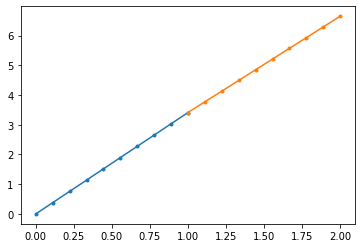

In [103]:
plt.plot(alphas, dot_prods0, marker='.')
plt.plot(alphas+1, dot_prods1, marker='.')

## For euclidean distance

In [104]:
### From zeros to G
dists0 = []
for alpha in alphas:
    A = alpha*G #+ (1-alpha)*W
    d = np.linalg.norm((A-G).reshape(-1), ord=2)  ### calculating the euclidean_distance
    dists0.append(d)

### From G to ones
dists1 = []
for alpha in alphas:
    A = alpha*W + (1-alpha)*G
    d = np.linalg.norm((A-G).reshape(-1), ord=2)  ### calculating the euclidean_distance
    dists1.append(d)

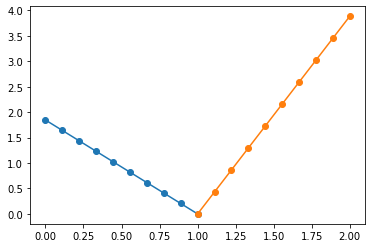

In [105]:
plt.plot(alphas, dists0, marker='o')
plt.plot(alphas+1, dists1, marker='o')

## For angle / cos(theta)

In [124]:
### From zeros to G
dists0 = []
for alpha in alphas:
    A = alpha*G #+ (1-alpha)*W
    u, v = A.reshape(-1), G.reshape(-1)
    d = np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v)) ## calculating cosine angle
#     d = np.dot(u,v)/np.linalg.norm(u)/np.linalg.norm(v) ## calculating cosine angle
    d = np.clip(d, -1, 1)
    dists0.append(d)

### From G to ones
dists1 = []
for alpha in alphas:
    A = alpha*W + (1-alpha)*G
    u, v = A.reshape(-1), G.reshape(-1)
    d = np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v)+1e-15) ## calculating cosine angle
    d = np.clip(d, -1, 1)
    dists1.append(d)

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


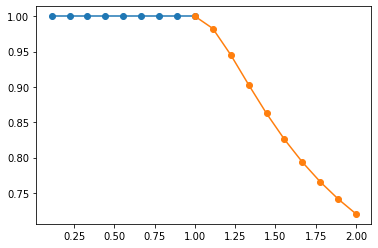

In [125]:
plt.plot(alphas, dists0, marker='o')
plt.plot(alphas+1, dists1, marker='o')

## For 2D vector, compare dot product to distance

In [126]:
a = np.array([1, 0.1])
b = np.array([
    [1.1, 0.2],
    [1.1, 0.9]
])

In [130]:
a@b.T

array([1.12, 1.19])

In [132]:
### slope of a:
# _m = a[1]/a[0]
### slope of perpendicular line
# _tm = -1/_m
_tm = -a[0]/a[1]
### equation of line passing through point(a) and slope _tm
x = np.array([0.8, 1.1])
_y = _tm*(x-a[0])+a[1]
_y

array([ 2.1, -0.9])

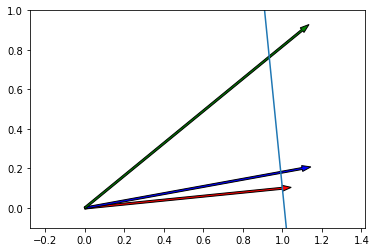

In [139]:
plt.arrow(0, 0, a[0], a[1], width=0.01, facecolor='r')
plt.arrow(0, 0, b[0,0], b[0,1], width=0.01, facecolor='b')
plt.arrow(0, 0, b[1,0], b[1,1], width=0.01, facecolor='g')

plt.plot(x, _y)

plt.axis('equal')
# plt.xlim(-0.1, 1.4)
plt.ylim(-0.1, 1.0)

plt.show()

In [ ]:
-1/